In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
import sys as sys
import time
import matplotlib.pyplot as plt

This function just allows me to have easy control over the prettier plotting colors.

In [2]:
def ColorDefault(k):
    if (k == 0):
        color = '#1f77b4'  # blue
    else:
        if (k % 9 == 0):
            color = '#17becf'  # cyan
        else:
            if (k % 8 == 0):
                color = '#bcbd22'  # sickly greenish tan
            else:
                if (k % 7 == 0):
                    color = '#7f7f7f'  # grey
                else:
                    if (k % 6 == 0):
                        color = '#e377c2'  # pink
                    else:
                        if (k % 5 == 0):
                            color = '#8c564b'  # brown
                        else:
                            if (k % 4 == 0):
                                color = '#9467bd'  # purple
                            else:
                                if (k % 3 == 0):
                                    color = '#d62728'  # red
                                else:
                                    if (k % 2 == 0):
                                        color = '#2ca02c'  # green
                                    else:
                                        color = '#ff7f0e'  # orange
    return color

This function checks to make sure that sizes match up appropriately.

In [3]:
def CheckSize(nh, checkMatrix):
    dim = size(shape(checkMatrix))
    problem = 0
    for i in range(dim):
        if (nh != shape(checkMatrix)[i]):
            problem = problem + 1
    return problem

This function outputs an $x$ array and a $y$ array of size $n^{h}$ + 1 of the locations of the tick marks.

In [4]:
def MakeXY(nh):
    x = np.linspace(0, 1, num = nh + 1)
    y = np.zeros(nh + 1, float)
    return x, y

This function returns a tick mark of height `h` at location (`xCenter`, `yCenter`).

In [5]:
def DrawLine(xCenter, yCenter, h):
    x = xCenter * np.ones(2)
    y = linspace(yCenter - (h / 2), yCenter + (h / 2), num = 2)
    return (x, y)

This function plots a number line with $n^{h}$ cells onto `ax`.

In [6]:
def TickPlot(nh, ax):
    xAxis, yAxis = MakeXY(nh)
    for (xi, yi) in zip(xAxis, yAxis):
        if ((xi == 0) or (xi == 1)):
            h = 0.5
        else:
            h = 0.25
        (xs, ys) = DrawLine(xi, yi, h)
        ax.plot(xs, ys, color = 'k', zorder = 1)
    ax.plot(xAxis, yAxis, color = 'k', zorder = 0)
    plt.xlim([-0.1, 1.25])
    plt.ylim([-2.5, 2.5])
    plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
    plt.tick_params(axis = 'y', which = 'both', left = False, right = False, labelleft = False)
    return

This function plots out the piecewise cell averages.

In [7]:
def Averages(nh, numPoints, X, aveVals):
    problemX = CheckSize(numPoints, X)
    problemAve = CheckSize(nh, aveVals)
    if (problemX != 0):
        sys.exit('ERROR:\nAverages:\nnumPoints does not match size of X!')
    if (problemAve != 0):
        sys.exit('ERROR:\nAverages:\nnh does not match size of aveVals!')
    x, y = MakeXY(nh)
    cellVals = np.ones(numPoints, float)
    lowIndex = 0
    for k in range(nh):
        highIndex = np.where(X <= x[k + 1])[0][::-1][0] + 1
        cellVals[lowIndex:highIndex] = aveVals[k] * cellVals[lowIndex:highIndex]
        plt.plot(X[lowIndex:highIndex], cellVals[lowIndex:highIndex], color = ColorDefault(3), zorder = 3)
        lowIndex = highIndex
    return

This function creates a matrix of cell-centered Fourier modes along with a linear space of the cell locations.

In [8]:
def MakeWaves(nh, dx):
    x, y = MakeXY(nh)
    waves = np.zeros((nh, nh), float)
    xCell = x[0:nh] + (dx / 2.)
    for k in range(int(nh / 2)):
        waves[:, (2 * k) + 1] = (1.0 / (2.0 * np.pi * (k + 1) * dx)) * (cos(2 * np.pi * (k + 1) * x[0:nh]) - cos(2 * np.pi * (k + 1) * x[1:nh + 1]))
        if (k == 0):
            waves[:, 2 * k] = np.ones(nh, float)
        else:
            waves[:, 2 * k] = (1.0 / (2.0 * np.pi * k * dx)) * (sin(2 * np.pi * k * x[1:nh + 1]) - sin(2 * np.pi * k * x[0:nh]))
    return xCell, waves

This function creates a matrix of node-centered Fourier modes along with a linear space of the node locations.

In [9]:
def MakeNodeWaves(nh, dx):
    x = np.linspace(0, 1. - (1. / nh), num = nh)
    waves = np.zeros((nh, nh), float)
    for k in range(int(nh / 2)):
        waves[:, (2 * k) + 1] = np.sin(2 * np.pi * (k + 1) * x)
        if (k == 0):
            waves[:, 2 * k] = np.ones(nh, float)
        else:
            waves[:, 2 * k] = np.cos(2 * np.pi * k * x)
    return x, waves

This function allows for convenient control over ubiquitous plotting parameters and objects.

In [10]:
def UsefulPlotVals(nh):
    numPoints = 129
    X = linspace(0, 1, num = numPoints)
    font = 15
    return numPoints, X, font

This function overlays the piecewise cell average plots onto plots of their respective continuous wave functions alongside written labels of the equations they should each represent. It also gives the option of plotting the node point values. It also allows you to save those plots if desired. As the default, these two features are subdued.

In [11]:
def PlotWaves(nh, waveCell, x, waveNode, plotNode = False, save = False):
    problemCell = CheckSize(nh, waveCell)
    problemX = CheckSize(nh, x)
    problemNode = CheckSize(nh, waveNode)
    if (problemCell != 0):
        sys.exit('ERROR:\nPlotWaves:\nnh does not match size of waveCell!')
    if (problemX != 0):
        sys.exit('ERROR:\nPlotWaves:\nnh does not match size of x!')
    if (problemNode != 0):
        sys.exit('ERROR:\nPlotWaves:\nnh does not match size of waveNode!')
    numPoints, X, font = UsefulPlotVals(nh)
    for k in range(nh):
        fig, ax = plt.subplots(figsize = (5, 2.5))
        ax.set_aspect(aspect = 4)
        ax = plt.axes(frameon = False)
        if (k % 2 == 0):
            fX = np.cos(np.pi * k * X)
            if (k == 0):
                plt.text(1.1, 0, r'$\frac{a_{0}}{2}$', fontsize = font)
            else:
                plt.text(1.1, 0, r'$a_{%d}$' %(k / 2) + 'cos' + r'$%d \pi x$' %(k), fontsize = font)
        else:
            fX = np.sin(np.pi * (k + 1) * X)
            plt.text(1.1, 0, r'$b_{%d}$' %((k / 2) + 1) + 'sin' + r'$%d \pi x$' %(k + 1), fontsize = font)
        Averages(nh, numPoints, X, waveCell[:, k])
        TickPlot(nh, ax)
        plt.plot(X, fX, color = ColorDefault(0), zorder = 2)
        if (plotNode):
            plt.scatter(x, waveNode[:, k], color = ColorDefault(2), s = 10, zorder = 4)
        if (save):
            fig.savefig(savePath + 'FourierModes' + str(nh - k) + '.png', bbox_inches = 'tight', dpi = 600, transparent = True)
        plt.show()
    return

This function just plots the real and imaginary parts of an arbitrary matrix of functions alongside written notes of each of the wave equations to which they should correspond. It also allows you to save those plots and select their file names if desired. As the default, that feature is subdued.

In [12]:
def PlotGeneralWaves(nh, x, waves, save = False, saveName = 'PlotOutputs'):
    problemX = CheckSize(nh, x)
    problemWave = CheckSize(nh, waves)
    if (problemX != 0):
        sys.exit('ERROR:\nPlotGeneralWaves:\nnh does not match size of x!')
    if (problemWave != 0):
        sys.exit('ERROR:\nPlotGeneralWaves:\nnh does not match size of waves!')
    numPoints, X, font = UsefulPlotVals(nh)
    for k in range(nh):
        fig, ax = plt.subplots(figsize = (5, 2.5))
        ax.set_aspect(aspect = 4)
        ax = plt.axes(frameon = False)
        if (k % 2 == 0):
            if (k == 0):
                plt.text(1.1, 0, r'$\frac{a_{0}}{2}$', fontsize = font)
            else:
                plt.text(1.1, 0, r'$a_{%d}$' %(k / 2) + 'cos' + r'$%d \pi x$' %(k), fontsize = font)
        else:
            plt.text(1.1, 0, r'$b_{%d}$' %((k / 2) + 1) + 'sin' + r'$%d \pi x$' %(k + 1), fontsize = font)
        plt.plot(x, waves[:, k].real, color = ColorDefault(0), zorder = 2)
        plt.plot(x, waves[:, k].imag, color = ColorDefault(3), zorder = 3)
        TickPlot(nh, ax)
        if (save):
            fig.savefig(savePath + saveName + str(nh - k) + '.png', bbox_inches = 'tight', dpi = 600, transparent = True)
        plt.show()
    return

This cell is where you set your inputs. None of the other cells are designed to be modified.

In [13]:
savePath = '/Users/sashacurcic/SashasDirectory/ANAG/Figures/'
nh = 16

This cell just checks to make sure your inputs are valid.

In [14]:
check = nh
while (check % 2 == 0):
    check = check / 2
if (check != 1):
    sys.exit('ERROR:\nnh must be a base-2 integer!')

This cell and the four which follow it orchestrate and implement the main computations of the program.

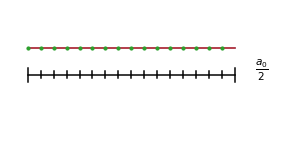

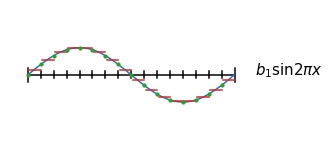

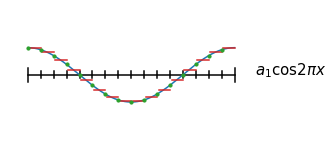

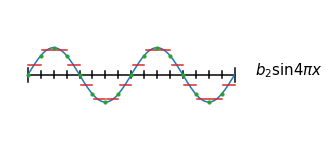

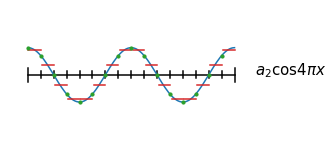

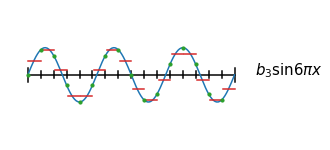

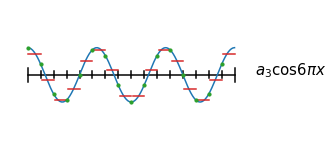

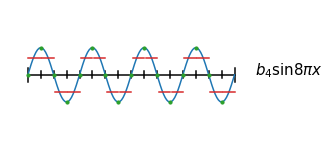

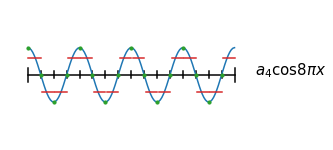

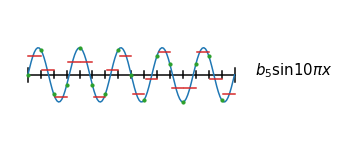

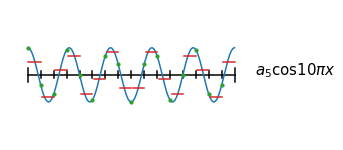

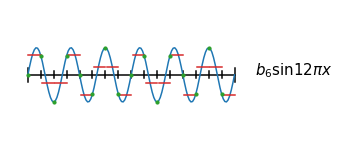

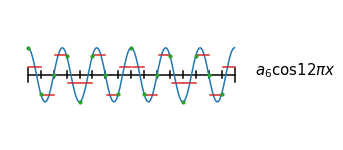

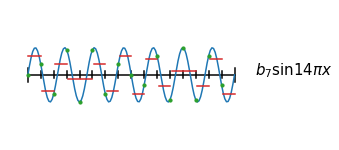

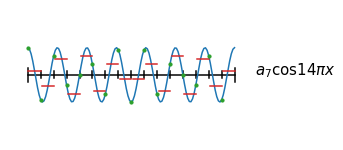

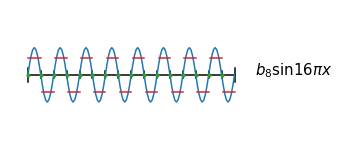

In [15]:
dx = 1. / nh
xCell, waveXBasis = MakeWaves(nh, dx)
xNode, waveXBasisNode = MakeNodeWaves(nh, dx)
PlotWaves(nh, waveXBasis, xNode, waveXBasisNode, plotNode = True)

In [16]:
fundFreq = np.cos((2. * np.pi) / nh) - 1j * np.sin((2. * np.pi) / nh)
halfFreq = fundFreq ** (0.5)
kVals = list(np.arange(nh))
kVals = kVals + kVals
ks = [int((i + 1) / 2) for i in kVals]
diagVec = [halfFreq ** k for k in ks]
cellShift = np.zeros((nh, nh), complex)
fill_diagonal(cellShift, diagVec)
waveXBasis = np.matmul(cellShift, waveXBasis)
cellFFT = dx * np.fft.fft(waveXBasis)
nodeFFT = dx * np.fft.fft(waveXBasisNode)
print(cellFFT)

[[ 6.06129748e-01+0.00000000e+00j -1.71934626e-02-4.56265802e-02j
   2.06316168e-02-1.04305487e-02j  2.68837942e-02+3.58873426e-03j
   2.92869538e-02+1.55486628e-02j  3.10043467e-02+3.01176743e-02j
   3.38931354e-02+5.47690031e-02j  5.01503787e-02+1.30955079e-01j
   4.45567258e-02+0.00000000e+00j  5.01503787e-02-1.30955079e-01j
   3.38931354e-02-5.47690031e-02j  3.10043467e-02-3.01176743e-02j
   2.92869538e-02-1.55486628e-02j  2.68837942e-02-3.58873426e-03j
   2.06316168e-02+1.04305487e-02j -1.71934626e-02+4.56265802e-02j]
 [ 6.59567033e-02-1.31196040e-02j  3.73967162e-02-3.62147228e-01j
   1.90002064e-02-8.48972020e-02j  2.61806097e-02-5.09318586e-02j
   3.11087342e-02-3.47837397e-02j  3.72276408e-02-2.45414746e-02j
   5.16568870e-02-1.79911168e-02j  2.11714331e-01-8.84978809e-02j
  -1.36227723e-01+2.70973788e-02j  2.29465210e-01+7.41814091e-04j
   5.46096429e-02-3.14661029e-03j  4.37854711e-02+8.42696470e-03j
   4.20518837e-02+2.02311880e-02j  4.36785079e-02+3.70360161e-02j
   5.0042

In [17]:
print(np.matmul(cellShift, cellFFT))

[[ 6.06129748e-01+0.00000000e+00j -1.71934626e-02-4.56265802e-02j
   2.06316168e-02-1.04305487e-02j  2.68837942e-02+3.58873426e-03j
   2.92869538e-02+1.55486628e-02j  3.10043467e-02+3.01176743e-02j
   3.38931354e-02+5.47690031e-02j  5.01503787e-02+1.30955079e-01j
   4.45567258e-02+0.00000000e+00j  5.01503787e-02-1.30955079e-01j
   3.38931354e-02-5.47690031e-02j  3.10043467e-02-3.01176743e-02j
   2.92869538e-02-1.55486628e-02j  2.68837942e-02-3.58873426e-03j
   2.06316168e-02+1.04305487e-02j -1.71934626e-02+4.56265802e-02j]
 [ 6.21298560e-02-2.57350290e-02j -3.39732706e-02-3.62484408e-01j
   2.07250029e-03-8.69726824e-02j  1.57412439e-02-5.50608008e-02j
   2.37250176e-02-4.01843928e-02j  3.17245179e-02-3.13326694e-02j
   4.71544217e-02-2.77231812e-02j  1.90381219e-01-1.28100836e-01j
  -1.28323709e-01+5.31534206e-02j  2.25200821e-01-4.40388813e-02j
   5.29464608e-02-1.37399619e-02j  4.45881648e-02-2.77078716e-04j
   4.51907775e-02+1.16385358e-02j  5.00646060e-02+2.78031253e-02j
   6.2964

In [18]:
print(nodeFFT)

[[ 5.00000000e-01+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   5.00000000e-01+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 3.76708718e-01+0.00000000e+00j -3.94366446e-02-2.46096830e-01j
   4.41941738e-02-8.59553387e-02j  5.68881117e-02-4.06448909e-02j
   6.25000000e-02-1.24320230e-02j  6.81118883e-02+1.35482970e-02j
   8.08058262e-02+4.93436863e-02j  1.64436645e-01+1.61649749e-01j
  -2.51708718e-01+0.00000000e+00j  1.64436645e-01-1.61649749e-01j
   8.08058262e-02-4.93436863e-02j  6.81118883e-02-1.35482970e-02j
   6.25000000e-02+1.24320230e-02j  5.68881117e-02+4.06448909e-02j
   4.4194

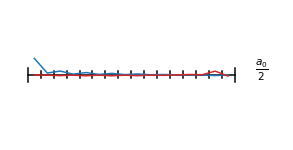

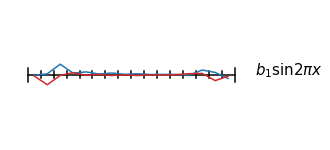

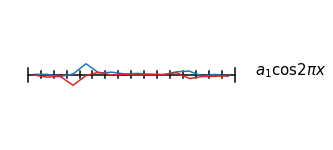

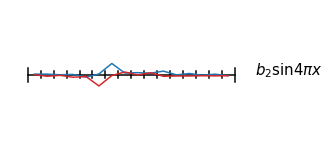

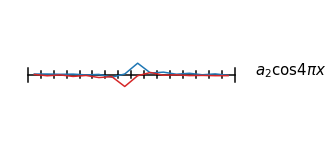

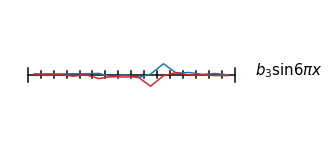

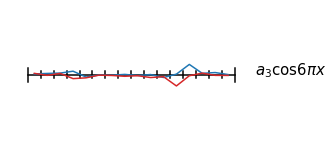

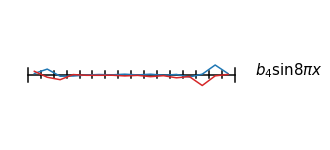

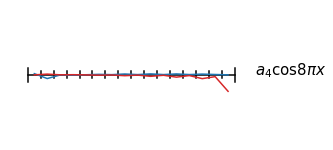

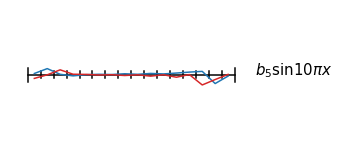

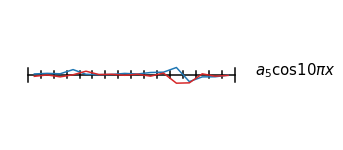

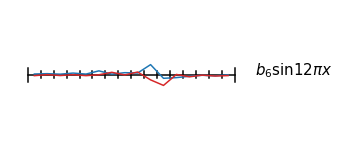

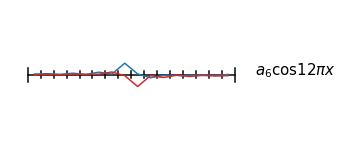

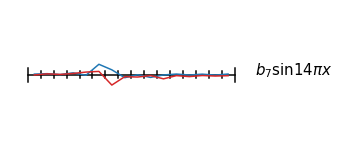

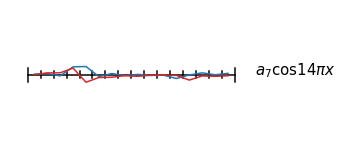

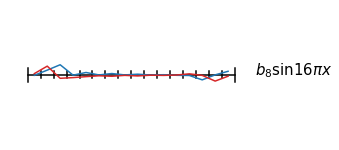

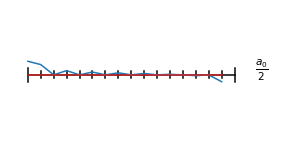

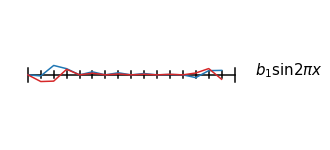

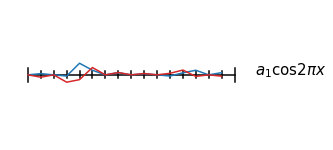

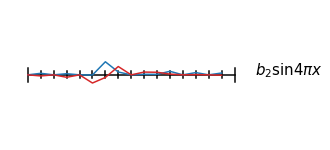

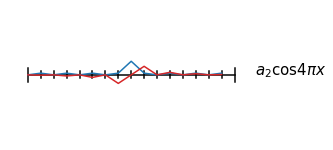

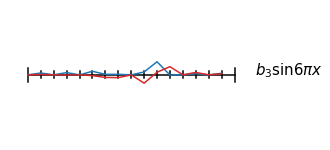

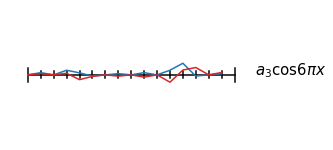

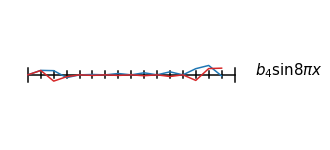

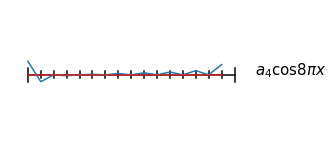

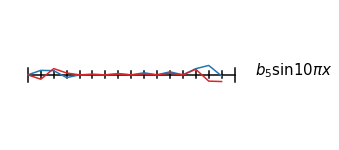

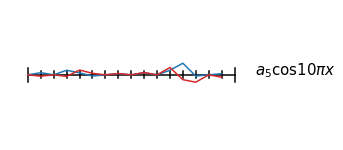

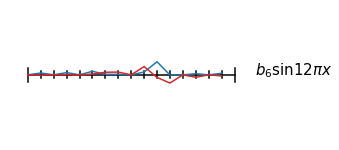

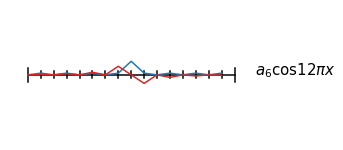

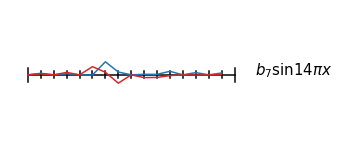

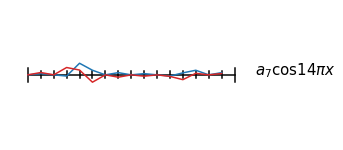

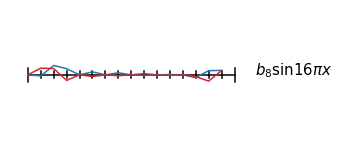

In [19]:
PlotGeneralWaves(nh, xCell, cellFFT)
PlotGeneralWaves(nh, xNode, nodeFFT)

This cell and all those below it just constitute a testing space.

In [20]:
points = 16
x = np.linspace(0, 1. - (1./points), num = points)
print(x)
s1 = np.sin(2 * np.pi * x)
print(s1)

[0.     0.0625 0.125  0.1875 0.25   0.3125 0.375  0.4375 0.5    0.5625
 0.625  0.6875 0.75   0.8125 0.875  0.9375]
[ 0.00000000e+00  3.82683432e-01  7.07106781e-01  9.23879533e-01
  1.00000000e+00  9.23879533e-01  7.07106781e-01  3.82683432e-01
  1.22464680e-16 -3.82683432e-01 -7.07106781e-01 -9.23879533e-01
 -1.00000000e+00 -9.23879533e-01 -7.07106781e-01 -3.82683432e-01]


In [21]:
s1fft = np.fft.fft(s1)
print(s1fft)

[-9.95799250e-17+0.00000000e+00j -1.26550410e-15-8.00000000e+00j
 -4.27067681e-16-6.60554663e-16j  1.91553812e-16-9.81427688e-16j
  2.33486982e-16-5.55111512e-16j  1.91553812e-16-9.32492680e-17j
  6.71997040e-16-4.38510058e-16j  3.92537761e-16+0.00000000e+00j
  1.22464680e-16+0.00000000e+00j  3.92537761e-16-0.00000000e+00j
  6.71997040e-16+4.38510058e-16j  1.91553812e-16+9.32492680e-17j
  2.33486982e-16+5.55111512e-16j  1.91553812e-16+9.81427688e-16j
 -4.27067681e-16+6.60554663e-16j -1.26550410e-15+8.00000000e+00j]


In [22]:
s1fft = np.round(s1fft)

In [23]:
s1fftshift = np.fft.fftshift(s1fft)

In [24]:
s1fftshift = (1. / points) * np.round(s1fftshift)
print(s1fftshift)

[ 0.+0.j   0.+0.j   0.+0.j   0.+0.j   0.+0.j   0.+0.j  -0.+0.j  -0.+0.5j
 -0.+0.j   0.-0.5j  0.-0.j   0.+0.j   0.+0.j   0.+0.j   0.+0.j   0.+0.j ]


In [25]:
c1 = np.cos(2 * np.pi * x)
print(c1)
print('')
c1fft = np.fft.fft(c1)
c1fftshift = np.fft.fftshift(c1fft)
c1fftshift = (1. / points) * np.round(c1fftshift)
print(c1fftshift)

[ 1.00000000e+00  9.23879533e-01  7.07106781e-01  3.82683432e-01
  6.12323400e-17 -3.82683432e-01 -7.07106781e-01 -9.23879533e-01
 -1.00000000e+00 -9.23879533e-01 -7.07106781e-01 -3.82683432e-01
 -1.83697020e-16  3.82683432e-01  7.07106781e-01  9.23879533e-01]

[ 0. +0.j  0. +0.j  0. +0.j  0. +0.j -0. +0.j -0. +0.j  0. +0.j  0.5+0.j
 -0. +0.j  0.5+0.j  0. +0.j  0. -0.j  0. -0.j  0. +0.j  0. +0.j  0. +0.j]
